<a href="https://colab.research.google.com/github/HiraiG/zerotsuku_5_academix/blob/main/10%E5%9B%9E/10_Diffusers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 拡散モデル勉強会 2

## テキストの再現

In [3]:
!pip install diffusers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 44.4 MB/s eta 0:00:00


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

(…)kpoints/scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

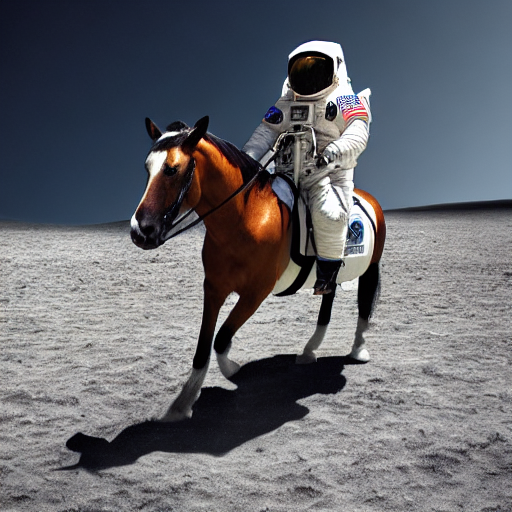

In [4]:
import torch
from diffusers import StableDiffusionPipeline

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # np.random.seed(seed)
    # random.seed(seed)
    # torch.backends.cudnn.benchmark = False
    # torch.backends.cudnn.deterministic = True

set_seed(seed = 123 )

pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4")
pipe = pipe.to("cuda")
prompt = "a photograph of an astronaut riding a horse"
image = pipe(prompt).images[0]
image

In [5]:
!pip install beartype
!pip install einops
!pip install classifier_free_guidance_pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 917.8/917.8 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 24.9 MB/s eta 0:00:00


## 拡散モデルの応用

### ライブラリのインポート

In [6]:
import torch
import torch.nn.functional as F
from torch import nn, einsum

from typing import List, Optional, Callable, Tuple
from beartype import beartype

from einops import pack, unpack, repeat, reduce, rearrange
from einops.layers.torch import Rearrange, Reduce

from functools import partial

from classifier_free_guidance_pytorch import TextConditioner, AttentionTextConditioner, classifier_free_guidance

from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler,DPMSolverMultistepScheduler, DiffusionPipeline
from diffusers.utils import export_to_video

import random
import numpy as np

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    # random.seed(seed)
    # torch.backends.cudnn.benchmark = False
    # torch.backends.cudnn.deterministic = True

device = "cuda" if torch.cuda.is_available() else "cpu"

### ヘルパー関数

In [7]:
def exists(val):
    return val is not None

def default(val, d):
    return val if exists(val) else d

def cast_tuple(val, length = 1):
    return val if isinstance(val, tuple) else ((val,) * length)

def pack_one(x, pattern):
    return pack([x], pattern)

def unpack_one(x, ps, pattern):
    return unpack(x, ps, pattern)[0]

### 位置エンコード

In [8]:
def posemb_sincos_1d(seq,
                     dim,
                     temperature = 10000,
                     device = None,
                     dtype = torch.float32
):
    """
    Sinusoidal位置エンコード
    ---------------------
    seq : シーケンス長
    dim : 次元数
    temperature : スケーリング係数
    device : デバイス（GPU or CPU)
    dtype : データ型
    """
    n = torch.arange(seq, device = device)
    omega = torch.arange(dim // 2, device = device) / (dim // 2 - 1)
    omega = 1. / (temperature ** omega)

    n = n[:, None] * omega[None, :]
    pos_emb = torch.cat((n.sin(), n.cos()), dim = 1)
    return pos_emb.type(dtype)

### 残差ブロック

In [9]:
class Residual(nn.Module):
    """
    残差ブロック
    """
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x):
        return self.fn(x) + x

### Layer正規化

In [10]:
class LayerNorm(nn.Module):
    """
    Layer正規化
    ---------------------
    dim : 次元数
    """
    def __init__(self, dim):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(dim))
        self.register_buffer("beta", torch.zeros(dim))

    def forward(self, x):
        return F.layer_norm(x, x.shape[-1:], self.gamma, self.beta)

### FeedForward NN

In [11]:
class FeedForward(nn.Module):
    """
    FeedForward NN
    ---------------------
    dim : 次元数
    mult : 次元の倍率
    dropout : ドロップアウト率
    """
    def __init__(self,
                 dim,
                 mult = 4,
                 dropout = 0.
    ):
        super().__init__()
        inner_dim = int(dim * mult)
        self.norm = LayerNorm(dim)

        self.net = nn.Sequential(
            nn.Linear(dim, inner_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x, cond_fn = None):
        x = self.norm(x)

        if exists(cond_fn):
            # adaptive layernorm
            x = cond_fn(x)

        return self.net(x)

### SE ブロック

In [12]:
class SqueezeExcitation(nn.Module):
    """
    SE ブロック
    多重共線性の回避
    任意サイズの画像入力可能に
    ---------------------
    dim : 次元数
    shrinkage_rate : 圧縮率
    """
    def __init__(self,
                 dim,
                 shrinkage_rate = 0.25
    ):
        super().__init__()
        hidden_dim = int(dim * shrinkage_rate)

        self.gate = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(dim, hidden_dim, bias = False),
            nn.SiLU(),
            nn.Linear(hidden_dim, dim, bias = False),
            nn.Sigmoid(),
            nn.unsqueeze(1), # (b,c) -> (b,c,1)
            nn.unsqueeze(-1) # (b,c,1) -> (b,c,1,1)
        )

    def forward(self, x):
        return x * self.gate(x)

### MBConv

In [13]:
class MBConvResidual(nn.Module):
    """
    MBConv
    ---------------------
    fn : 関数
    dropout : ドロップアウト率
    """
    def __init__(self,
                 fn,
                 dropout = 0.
    ):
        super().__init__()
        self.fn = fn
        self.dropsample = Dropsample(dropout)

    def forward(self, x):
        out = self.fn(x)
        out = self.dropsample(out)
        return out + x

class Dropsample(nn.Module):
    """
    ドロップアウト
    ---------------------
    prob : ドロップアウト率
    """
    def __init__(self, prob = 0):
        super().__init__()
        self.prob = prob

    def forward(self, x):
        device = x.device

        if self.prob == 0. or (not self.training):
            return x

        keep_mask = torch.FloatTensor((x.shape[0], 1, 1, 1), device = device).uniform_() > self.prob
        return x * keep_mask / (1 - self.prob)


def MBConv(
    dim_in,
    dim_out,
    *,
    downsample,
    expansion_rate = 4,
    shrinkage_rate = 0.25,
    dropout = 0.
):
    """
    MBConv
    "---------------------
    dim_in : 入力次元数
    dim_out : 出力次元数
    downsample : ダウンサンプリング
    expansion_rate : 拡張率
    shrinkage_rate : 圧縮率
    dropout : ドロップアウト率
    """
    hidden_dim = int(expansion_rate * dim_out)
    stride = 2 if downsample else 1

    net = nn.Sequential(
        nn.Conv2d(dim_in, hidden_dim, 1),
        nn.BatchNorm2d(hidden_dim),
        nn.GELU(),
        nn.Conv2d(hidden_dim, hidden_dim, 3, stride = stride, padding = 1, groups = hidden_dim),
        nn.BatchNorm2d(hidden_dim),
        nn.GELU(),
        SqueezeExcitation(hidden_dim, shrinkage_rate = shrinkage_rate),
        nn.Conv2d(hidden_dim, dim_out, 1),
        nn.BatchNorm2d(dim_out)
    )

    if dim_in == dim_out and not downsample:
        net = MBConvResidual(net, dropout = dropout)

    return net

### 注意機構

In [14]:
class Attention(nn.Module):
    def __init__(
        self,
        dim,
        dim_head = 32,
        dropout = 0.,
        window_size = 7
    ):
        """
        dim : 次元数
        dim_head : ヘッドの次元数
        dropout : ドロップアウト率
        window_size : ウィンドウサイズ
        """
        super().__init__()
        assert (dim % dim_head) == 0, 'dimension should be divisible by dimension per head'

        self.norm = LayerNorm(dim)

        self.heads = dim // dim_head
        self.scale = dim_head ** -0.5

        self.to_qkv = nn.Linear(dim, dim * 3, bias = False)

        self.attend = nn.Sequential(
            nn.Softmax(dim = -1),
            nn.Dropout(dropout)
        )

        self.to_out = nn.Sequential(
            nn.Linear(dim, dim, bias = False),
            nn.Dropout(dropout)
        )

        self.rel_pos_bias = nn.Embedding((2 * window_size - 1) ** 2, self.heads)

        pos = torch.arange(window_size)
        grid = torch.stack(torch.meshgrid(pos, pos, indexing = 'ij'))
        grid = rearrange(grid, 'c i j -> (i j) c')
        rel_pos = rearrange(grid, 'i ... -> i 1 ...') - rearrange(grid, 'j ... -> 1 j ...')
        rel_pos += window_size - 1
        rel_pos_indices = (rel_pos * torch.tensor([2 * window_size - 1, 1])).sum(dim = -1)

        self.register_buffer('rel_pos_indices', rel_pos_indices, persistent = False)

    def forward(self, x):
        batch, height, width, window_height, window_width, _, device, h = *x.shape, x.device, self.heads
        # Layer正規化
        x = self.norm(x)
        # クエリの埋め込み、キー、バリューの埋め込み
        x = rearrange(x, 'b x y w1 w2 d -> (b x y) (w1 w2) d')
        # クエリ、キー、バリューを作成
        q, k, v = self.to_qkv(x).chunk(3, dim = -1)
        # クエリ、キー、バリューをヘッドに分割
        q, k, v = map(lambda t: rearrange(t, 'b n (h d ) -> b h n d', h = h), (q, k, v))
        # クエリのスケーリング
        q = q * self.scale
        # スコアの計算
        sim = einsum('b h i d, b h j d -> b h i j', q, k)
        # バイアスの定義
        bias = self.rel_pos_bias(self.rel_pos_indices)
        # バイアスの適用
        sim = sim + rearrange(bias, 'i j h -> h i j')
        # 注意機構の適用
        attn = self.attend(sim)

        # バリューの適用
        out = einsum('b h i j, b h j d -> b h i d', attn, v)

        # 出力の適用
        out = rearrange(out, 'b h (w1 w2) d -> b w1 w2 (h d)', w1 = window_height, w2 = window_width)

        # 出力の適用
        out = self.to_out(out)
        #
        return rearrange(out, '(b x y) ... -> b x y ...', x = height, y = width)

### MaxViT（Multi AXis VIsion Transformer）

In [ ]:
class MaxViT(nn.Module):
    def __init__(
        self,
        *,
        num_classes,
        dim,
        depth,
        dim_head = 32,
        dim_conv_stem = None,
        window_size = 7,
        mbconv_expansion_rate = 4,
        mbconv_shrinkage_rate = 0.25,
        dropout = 0.1,
        channels = 3
    ):
        super().__init__()
        assert isinstance(depth, tuple), 'depth needs to be tuple if integers indicating number of transformer blocks at that stage'

        # convolutional stem

        dim_conv_stem = default(dim_conv_stem, dim)

        self.conv_stem = nn.Sequential(
            nn.Conv2d(channels, dim_conv_stem, 3, stride = 2, padding = 1),
            nn.Conv2d(dim_conv_stem, dim_conv_stem, 3, padding = 1)
        )

        # variables

        num_stages = len(depth)

        dims = tuple(map(lambda i: (2 ** i) * dim, range(num_stages)))
        dims = (dim_conv_stem, *dims)
        dim_pairs = tuple(zip(dims[:-1], dims[1:]))

        self.layers = nn.ModuleList([])

        # shorthand for window size for efficient block - grid like attention

        w = window_size

        # iterate through stages

        cond_hidden_dims = []

        for ind, ((layer_dim_in, layer_dim), layer_depth) in enumerate(zip(dim_pairs, depth)):
            for stage_ind in range(layer_depth):
                is_first = stage_ind == 0
                stage_dim_in = layer_dim_in if is_first else layer_dim

                cond_hidden_dims.append(stage_dim_in)

                block = nn.Sequential(
                    MBConv(
                        stage_dim_in,
                        layer_dim,
                        downsample = is_first,
                        expansion_rate = mbconv_expansion_rate,
                        shrinkage_rate = mbconv_shrinkage_rate
                    ),
                    Rearrange('b d (x w1) (y w2) -> b x y w1 w2 d', w1 = w, w2 = w),  # block-like attention
                    Residual(Attention(dim = layer_dim, dim_head = dim_head, dropout = dropout, window_size = w)),
                    Residual(FeedForward(dim = layer_dim, dropout = dropout)),
                    Rearrange('b x y w1 w2 d -> b d (x w1) (y w2)'),

                    Rearrange('b d (w1 x) (w2 y) -> b x y w1 w2 d', w1 = w, w2 = w),  # grid-like attention
                    Residual(Attention(dim = layer_dim, dim_head = dim_head, dropout = dropout, window_size = w)),
                    Residual(FeedForward(dim = layer_dim, dropout = dropout)),
                    Rearrange('b x y w1 w2 d -> b d (w1 x) (w2 y)'),
                )

                self.layers.append(block)

        embed_dim = dims[-1]
        self.embed_dim = dims[-1]

        self.cond_hidden_dims = cond_hidden_dims

        # mlp head out

        self.mlp_head = nn.Sequential(
            Reduce('b d h w -> b d', 'mean'),
            LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )

    @beartype
    def forward(
        self,
        x,
        texts: Optional[List[str]] = None,
        cond_fns: Optional[Tuple[Callable, ...]] = None,
        cond_drop_prob = 0.,
        return_embeddings = False
    ):
        x = self.conv_stem(x)

        if not exists(cond_fns):
            cond_fns = (None,) * len(self.layers)

        for stage, cond_fn in zip(self.layers, cond_fns):
            if exists(cond_fn):
                x = cond_fn(x)

            x = stage(x)

        if return_embeddings:
            return x

        return self.mlp_head(x)

### Transformer用注意機構

In [ ]:
class TransformerAttention(nn.Module):
    def __init__(
        self,
        dim,
        causal = False,
        dim_head = 64,
        dim_context = None,
        heads = 8,
        norm_context = False,
        dropout = 0.1
    ):
        super().__init__()
        self.heads = heads
        self.scale = dim_head ** -0.5
        self.causal = causal
        inner_dim = dim_head * heads

        dim_context = default(dim_context, dim)

        self.norm = LayerNorm(dim)
        self.context_norm = LayerNorm(dim_context) if norm_context else nn.Identity()

        self.attn_dropout = nn.Dropout(dropout)

        self.to_q = nn.Linear(dim, inner_dim, bias = False)
        self.to_kv = nn.Linear(dim_context, dim_head * 2, bias = False)
        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim, bias = False),
            nn.Dropout(dropout)
        )

    def forward(
        self,
        x,
        context = None,
        mask = None,
        attn_bias = None,
        attn_mask = None,
        cond_fn: Optional[Callable] = None
    ):
        b = x.shape[0]

        if exists(context):
            context = self.context_norm(context)

        kv_input = default(context, x)

        x = self.norm(x)

        if exists(cond_fn):
            # adaptive layer-norm
            x = cond_fn(x)

        q, k, v = self.to_q(x), *self.to_kv(kv_input).chunk(2, dim = -1)

        q = rearrange(q, 'b n (h d) -> b h n d', h = self.heads)

        q = q * self.scale

        sim = einsum('b h i d, b j d -> b h i j', q, k)

        if exists(attn_bias):
            sim = sim + attn_bias

        if exists(attn_mask):
            sim = sim.masked_fill(~attn_mask, -torch.finfo(sim.dtype).max)

        if exists(mask):
            mask = rearrange(mask, 'b j -> b 1 1 j')
            sim = sim.masked_fill(~mask, -torch.finfo(sim.dtype).max)

        if self.causal:
            i, j = sim.shape[-2:]
            causal_mask = torch.ones((i, j), dtype = torch.bool, device = x.device).triu(j - i + 1)
            sim = sim.masked_fill(causal_mask, -torch.finfo(sim.dtype).max)

        attn = sim.softmax(dim = -1)
        attn = self.attn_dropout(attn)

        out = einsum('b h i j, b j d -> b h i d', attn, v)

        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)


### Transformer

In [ ]:
@beartype
class Transformer(nn.Module):
    def __init__(
        self,
        dim,
        dim_head = 64,
        heads = 8,
        depth = 6,
        attn_dropout = 0.,
        ff_dropout = 0.
    ):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                TransformerAttention(dim = dim, heads =  heads, dropout = attn_dropout),
                FeedForward(dim = dim, dropout = ff_dropout)
            ]))

    def forward(
        self,
        x,
        cond_fns: Optional[Tuple[Callable, ...]] = None,
        attn_mask = None
    ):
        if not exists(cond_fns):
            cond_fns = (None,) * len(self.layers * 2)

        cond_fns = iter(cond_fns)

        for attn, ff in self.layers:
             x = attn(x, attn_mask = attn_mask, cond_fn = next(cond_fns)) + x
             x = ff(x, cond_fn = next(cond_fns)) + x
        return x

### TokenLearner

In [ ]:
class TokenLearner(nn.Module):
    """
    https://arxiv.org/abs/2106.11297
    using the 1.1 version with the MLP (2 dense layers with gelu) for generating attention map
    """

    def __init__(
        self,
        *,
        dim,
        ff_mult = 2,
        num_output_tokens = 8,
        num_layers = 2
    ):
        super().__init__()
        inner_dim = dim * ff_mult * num_output_tokens

        self.num_output_tokens = num_output_tokens
        self.net = nn.Sequential(
            nn.Conv2d(dim * num_output_tokens, inner_dim, 1, groups = num_output_tokens),
            nn.GELU(),
            nn.Conv2d(inner_dim, num_output_tokens, 1, groups = num_output_tokens),
        )

    def forward(self, x):
        x, ps = pack_one(x, '* c h w')
        x = repeat(x, 'b c h w -> b (g c) h w', g = self.num_output_tokens)
        attn = self.net(x)

        attn = rearrange(attn, 'b g h w -> b 1 g h w')
        x = rearrange(x, 'b (g c) h w -> b c g h w', g = self.num_output_tokens)

        x = reduce(x * attn, 'b c g h w -> b c g', 'mean')
        x = unpack_one(x, ps, '* c n')
        return x

### ImageDataGenerator

In [ ]:
class ImageDataGenerator:
    def __init__(
        self,
        model_id: str = "stabilityai/stable-diffusion-2",
        prompt: str = None,
        save_path: str = "generated_images"
    ):
        super().__init__()

        self.scheduler = EulerDiscreteScheduler.from_pretrained(
            model_id,
            subfolder="scheduler"
        )
        self.pipe = StableDiffusionPipeline.from_pretrained(
            model_id,
            scheduler=self.scheduler,
            torch_dtype=torch.float16
        )
        self.pipe = self.pipe.to("cuda")
        self.save_path = save_path

    def generate(self, prompt):
        image = self.pipe(prompt).images[0]
        # Assuming the output is a PIL image
        image.save(f"{self.save_path}.jpg")
        return image

### VideoDataGenerator

In [ ]:
class VideoDataGenerator:
    def __init__(
        self,
        model_id="cerspense/zeroscope_v2_576w",
        prompt: str = None,
        num_inference_steps=40,
        height=320,
        width=576,
        num_frames=24
    ):
        super().__init__()

        self.export_to_video = export_to_video

        self.model_id = model_id
        self.prompt = prompt
        self.num_inference_steps = num_inference_steps
        self.height = height
        self.width = width
        self.num_frames = num_frames

        self.pipe = DiffusionPipeline.from_pretrained(
            model_id,
            torch_dtype=torch.float16
        )
        self.pipe.scheduler = DPMSolverMultistepScheduler.from_config(self.pipe.scheduler.config)
        self.pipe.enable_model_cpu_offload()

    def generate(self, prompt=None):
        prompt = self.prompt or prompt
        video_frames = self.pipe(
            prompt,
            num_inference_steps=self.num_inference_steps,
            height=self.height,
            width=self.width,
            num_frames=self.num_frames
        ).frames
        video_path = self.export_to_video(video_frames)

### Gato

In [ ]:
@beartype
class Gato(nn.Module):
    def __init__(
        self,
        *,
        vit: MaxViT,
        num_actions = 11,
        action_bins = 256,
        depth = 6,
        heads = 8,
        dim_head = 64,
        token_learner_ff_mult = 2,
        token_learner_num_layers = 2,
        token_learner_num_output_tokens = 8,
        cond_drop_prob = 0.2,
        use_attn_conditioner = False,
        conditioner_kwargs: dict = dict()
    ):
        """
        https://arxiv.org/abs/2205.06175
        """
        super().__init__()
        self.vit = vit

        self.num_vit_stages = len(vit.cond_hidden_dims)

        conditioner_klass = AttentionTextConditioner if use_attn_conditioner else TextConditioner

        self.conditioner = conditioner_klass(
            hidden_dims = (*tuple(vit.cond_hidden_dims), *((vit.embed_dim,) * depth * 2)),
            hiddens_channel_first = (*((True,) * self.num_vit_stages), *((False,) * depth * 2)),
            cond_drop_prob = cond_drop_prob,
            **conditioner_kwargs
        )

        self.token_learner = TokenLearner(
            dim = vit.embed_dim,
            ff_mult = token_learner_ff_mult,
            num_output_tokens = token_learner_num_output_tokens,
            num_layers = token_learner_num_layers
        )

        self.num_learned_tokens = token_learner_num_output_tokens

        self.transformer_depth = depth

        self.transformer = Transformer(
            dim = vit.embed_dim,
            dim_head = dim_head,
            heads = heads,
            depth = depth
        )

        self.cond_drop_prob = cond_drop_prob

        self.to_logits = nn.Sequential(
            LayerNorm(vit.embed_dim),
            nn.Linear(vit.embed_dim, num_actions * action_bins),
            Rearrange('... (a b) -> ... a b', b = action_bins)
        )

    @classifier_free_guidance
    def forward(
        self,
        video,
        texts: Optional[List[str]] = None,
        cond_drop_prob = 0.
    ):
        depth = self.transformer_depth
        cond_drop_prob = default(cond_drop_prob, self.cond_drop_prob)

        frames, device = video.shape[2], video.device

        cond_fns = self.conditioner(
            texts,
            cond_drop_prob = cond_drop_prob,
            repeat_batch = (*((frames,) * self.num_vit_stages), *((1,) * self.transformer_depth * 2))
        )

        vit_cond_fns, transformer_cond_fns = cond_fns[:-(depth * 2)], cond_fns[-(depth * 2):]

        video = rearrange(video, 'b c f h w -> b f c h w')
        images, packed_shape = pack_one(video, '* c h w')

        tokens = self.vit(
            images,
            texts = texts,
            cond_fns = vit_cond_fns,
            cond_drop_prob = cond_drop_prob,
            return_embeddings = True
        )

        tokens = unpack_one(tokens, packed_shape, '* c h w')
        learned_tokens = self.token_learner(tokens)

        learned_tokens = rearrange(learned_tokens, 'b f c n -> b (f n) c')

        # causal attention mask

        attn_mask = torch.ones((frames, frames), dtype = torch.bool, device = device).triu(1)
        attn_mask = repeat(attn_mask, 'i j -> (i r1) (j r2)', r1 = self.num_learned_tokens, r2 = self.num_learned_tokens)

        # sinusoidal positional embedding

        pos_emb = posemb_sincos_1d(frames, learned_tokens.shape[-1], dtype = learned_tokens.dtype, device = learned_tokens.device)

        learned_tokens = learned_tokens + repeat(pos_emb, 'n d -> (n r) d', r = self.num_learned_tokens)

        # attention

        attended_tokens = self.transformer(learned_tokens, cond_fns = transformer_cond_fns, attn_mask = ~attn_mask)

        pooled = reduce(attended_tokens, 'b (f n) d -> b f d', 'mean', f = frames)

        logits = self.to_logits(pooled)
        return logits

### RoboCat

In [ ]:
class RoboCat:
    def __init__(
        self,
        num_classes = 1000,
        dim_conv_stem = 64,
        dim = 96,
        dim_head = 32,
        depth = (2, 2, 5, 2),
        window_size = 7,
        mbconv_expansion_rate = 4,
        mbconv_shrinkage_rate = 0.25,
        dropout = 0.1,
        num_actions=11,
        model_depth=6,
        heads=8,
        model_dim_head=64,
        cond_drop_prob=0.2
    ):
        super().__init__()

        self.vit = MaxViT(
            num_classes=num_classes,
            dim_conv_stem=dim_conv_stem,
            dim=dim,
            dim_head=dim_head,
            depth=depth,
            window_size=window_size,
            mbconv_expansion_rate=mbconv_expansion_rate,
            mbconv_shrinkage_rate=mbconv_shrinkage_rate,
            dropout=dropout
        )

        self.model = Gato(
            vit=self.vit,
            num_actions=num_actions,
            depth=model_depth,
            heads=heads,
            dim_head=model_dim_head,
            cond_drop_prob=cond_drop_prob
        )

    def forward(
            self,
            video,
            instructions
        ):
        return self.model(video, instructions)
        # eval = self.model.eval()
        # eval_logits = self.model(video, text, cond_scale=3.)